In [1]:
#import libraries to read dicom files and plotting
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import os
import cv2
import seaborn as sns


In [2]:
#load all dicom images in folder brain_ct_data using pydicom
images = []
for filename in os.listdir('brain_ct_data'):
    if filename.endswith(".dcm"):
        images.append(dicom.dcmread(os.path.join('brain_ct_data', filename)))


In [3]:
print("length of images: ", len(images))

length of images:  160


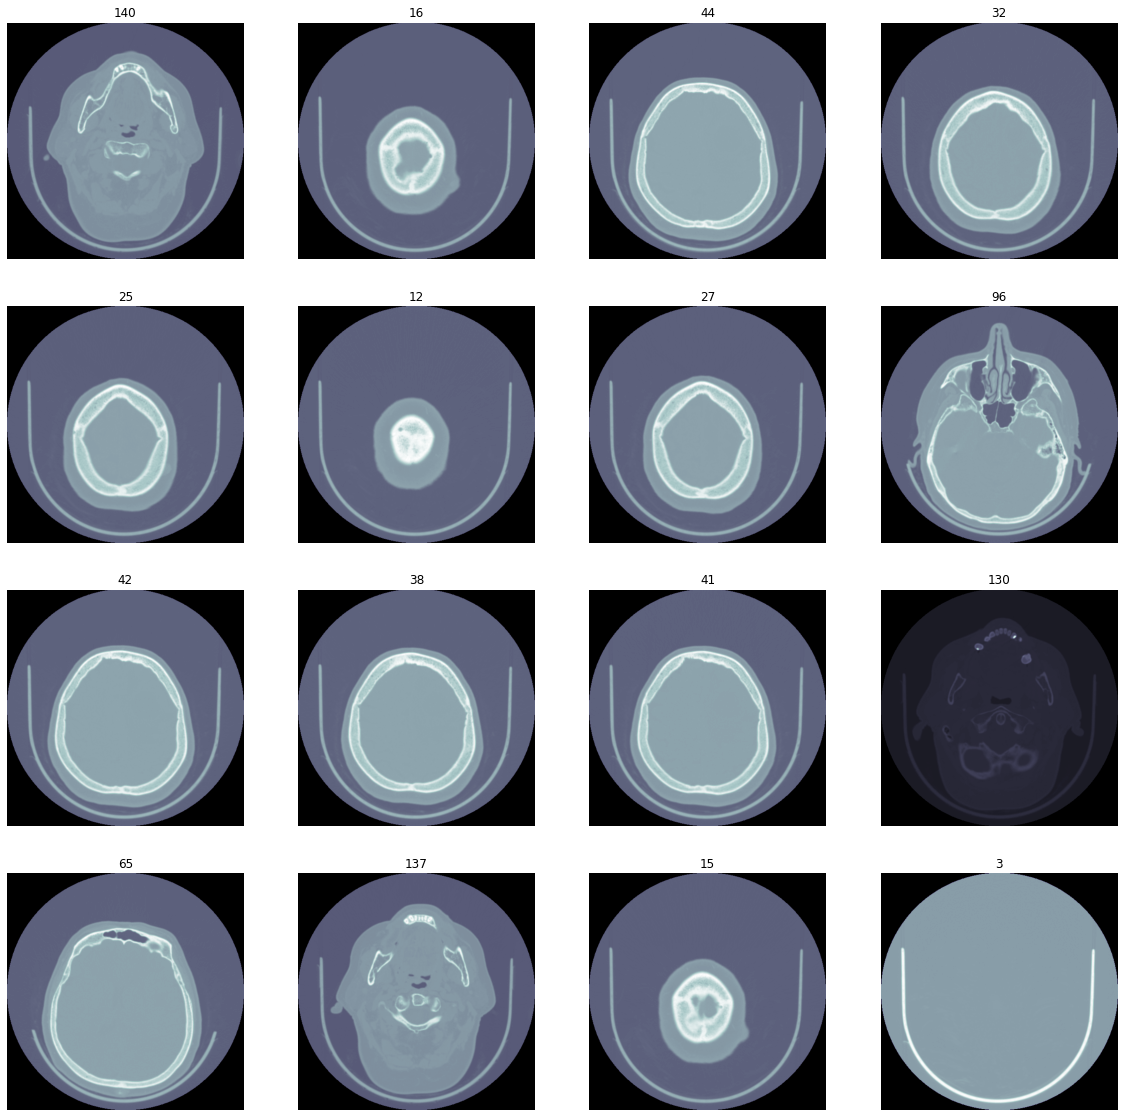

In [26]:
#in a 4x4 plot visualize slices from 70-86
plt.figure(figsize=(20,20))
#from 70 to 86
for i in range(70,86):
    plt.subplot(4,4,i-69)
    plt.imshow(images[i].pixel_array, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title(images[i].InstanceNumber)
plt.show()


In [9]:
#sort images by instance number
images_sorted = images.copy()
images_sorted.sort(key=lambda x: x.InstanceNumber)

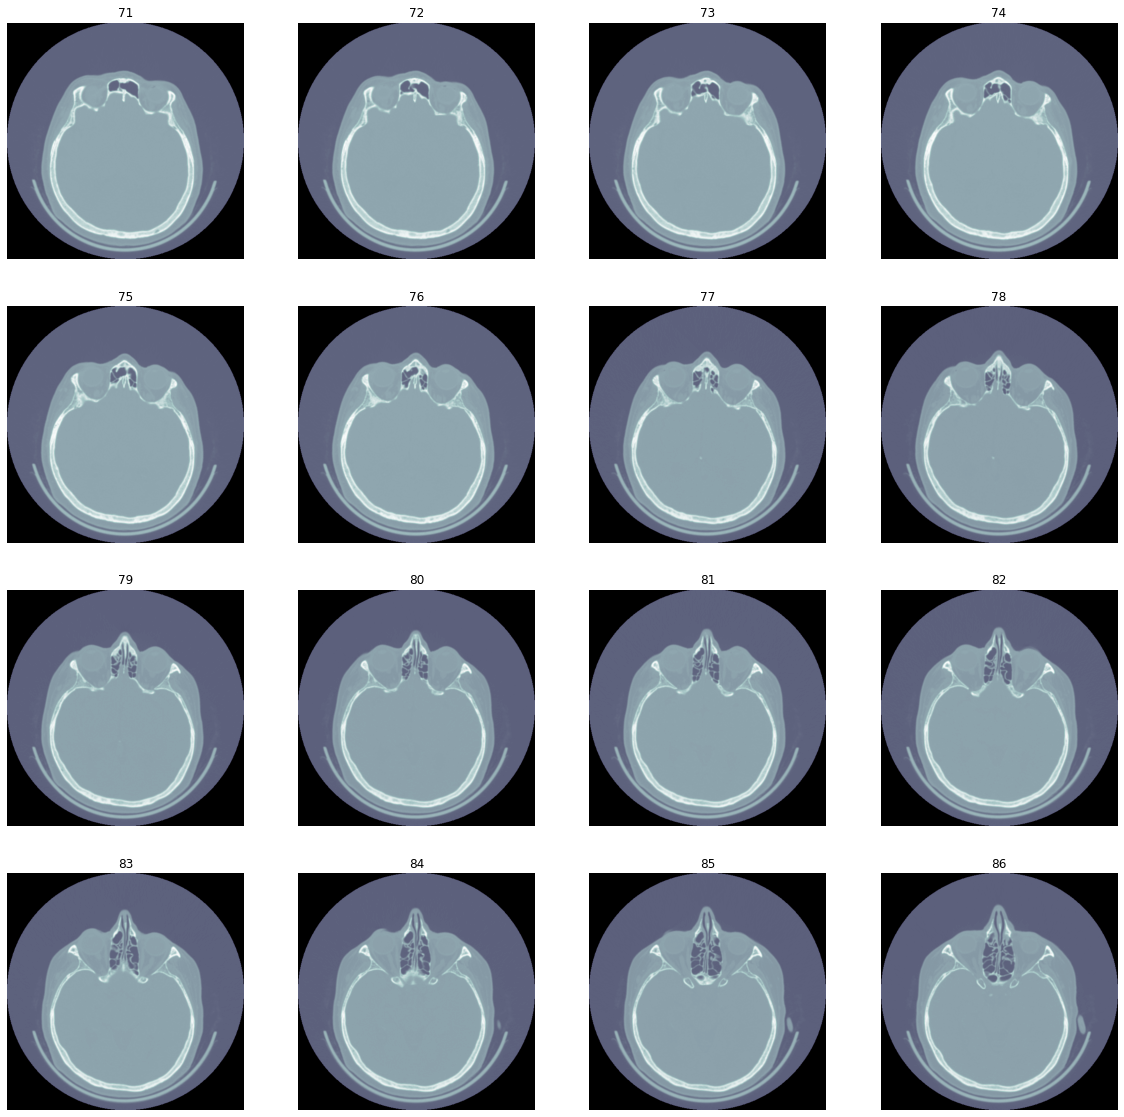

In [25]:
#in a 4x4 plot visualize slices from 70-86
plt.figure(figsize=(20,20))
#from 70 to 86
for i in range(70,86):
    plt.subplot(4,4,i-69)
    plt.imshow(images_sorted[i].pixel_array, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title(images_sorted[i].InstanceNumber)
plt.show()




In [36]:
#convert to 3d array and visualize using itk
import itk
from itkwidgets import view

image = np.zeros((len(images_sorted),512,512))
for i in range(len(images_sorted)):
    image[i] = images_sorted[i].pixel_array

view(image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [40]:
#we want to correct spacing and slice thickness
itk_image = itk.GetImageFromArray(image)
itk_image.SetSpacing([images[0].PixelSpacing[0],
                     images[0].PixelSpacing[1], images[0].SliceThickness])
itk_image.SetOrigin([images[0].ImagePositionPatient[0],
                    images[0].ImagePositionPatient[1], images[0].ImagePositionPatient[2]])
view(itk_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [50]:
## Hounsfield scale
#HU = Gray_Value * slope + intercept
print(images[0].RescaleIntercept)
print(images[0].RescaleSlope)
imageHU = image.copy()
imageHU = imageHU * images[0].RescaleSlope + images[0].RescaleIntercept


-1024
1


In [53]:
#Get only the bone by setting HU to 1 for values above 700 and 0 for values below 700
# Get only yhe bones
imageHU[imageHU > 1200] = 0
imageHU[imageHU < 800] = 0

#me ta parakato pernw mono 0
#imageHU[imageHU > 700] = 1
#imageHU[imageHU <= 700] = 0


In [52]:
#find the total volume of the bone voxels
#we need to find how many voxels are considered bones (1) and multiply by the voxel size which needs to be calculated based on the dicom data
#we can use the pixel spacing and slice thickness
voxel_size = images[0].PixelSpacing[0] * images[0].PixelSpacing[1] * images[0].SliceThickness
bone_volume = np.sum(imageHU) * voxel_size
print("Bone volume: ", bone_volume)




Bone volume:  173754470.53520626


In [57]:
#based on the Hounsfield scale, we can calculate the mean HU value of the bone
#we can use the np.mean function
mean_bone_HU = np.mean(imageHU[imageHU > 0])
print("Mean bone HU: ", mean_bone_HU)

#find wite and gray matter 
#white == (HU > 20)
#gray == (HU < 45)
white_matter = imageHU[imageHU > 20]
gray_matter = imageHU[imageHU < 45]

#calculate the mean HU value of the white matter
mean_white_matter = np.mean(white_matter)
print("Mean white matter HU: ", mean_white_matter)
#calculate the mean HU value of the gray matter
mean_gray_matter = np.mean(gray_matter)
print("Mean gray matter HU: ", mean_gray_matter)



Mean bone HU:  991.9512831435208
Mean white matter HU:  991.9512831435208
Mean gray matter HU:  0.0


In [59]:
#Based on that, we have many pixels that are not actually white matter we need to create a filter 
#that takes the 3 immediate neighbors of a voxel and it will set its value to the mean of those 6 voxels
#if its not above 20, it will be set to 0

import scipy.ndimage as nd
image_filtered = imageHU.copy()
image_filtered[image_filtered > 20] = 0
image_filtered = nd.median_filter(image_filtered, size=3)
image_filtered[image_filtered > 20] = 0
view(image_filtered)


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…